# Exercise 1

The submission deadline is **04.11.2024 23:55.**

## Task Description

The goal of this exercise is to model the relationship between weather observations and the occurence of traffic disruptions in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2023 of Vienna.
 * reports on traffic disruptions in Vienna ffrom 2013 - 2023.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in: `HOME/shared/188.995-2024W/data/`. 

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
    - look at the relationship between the variables of interest
* model the relationship:
    - fit a model that classifies new traffic disruptions from weather observation data
    
    
**Note:** In case you encounter problems with loading and processing the data (tasks 1-5), we will provide you also with a pickled version of a preprocessed and merged datasets that you can use to complete the remaining parts of the exercise (tasks 6-8).

There is a total of 100 points that can be reached which are distributed in two notebooks in the following way:

Notebook A (this notebook), total 55 points:
 - Task 1: 20 points
 - Task 2: 15 points
 - Task 3: 10 points
 - Task 4: 5 points
 - Task 5: 5 points


 Notebook B, total 45 points:
 - Task 6: 15 points
 - Task 7: 20 points
 - Task 8: 10 points

In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing


## Task 1: Load Data (20 Points)

### 1.1: Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2023, 15 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files and their descriptions
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - Your resulting data frame should look as follows, with temperature in Celsius, air pressure in hecto Pascal, skyCover on a scale from 1-10, humidity in percent, windDir in compass directions, windBeauf in Beaufort and precip in millimeters.:
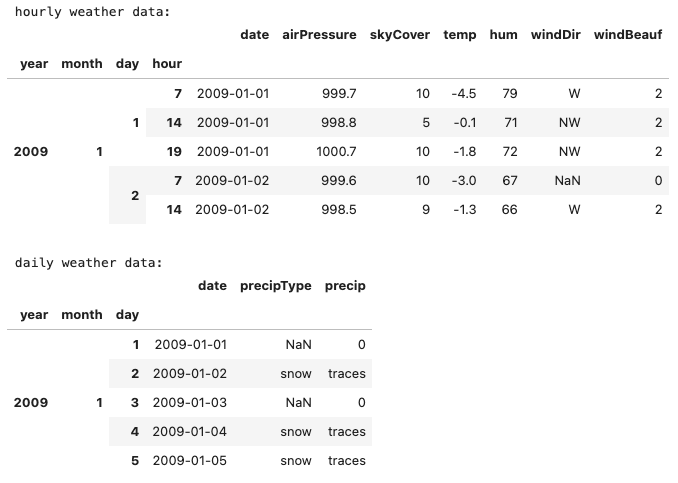

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_path = os.path.join(os.environ["HOME"], "shared", "188.995-2024W", "data")
weather_data_path = os.path.join(data_path, 'weather')
traffic_data_path = os.path.join(data_path, 'traffic')

In [5]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]: 
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    
    def split_columns(data):
        airPressure = []
        skyCover = []
        temp = []
        hum = []
        windDir = []
        windBeauf = []

        for item in data:
            if 'airPressure' in item:
                airPressure.append(item)
            elif 'skyCover' in item:
                skyCover.append(item)
            elif 'temp' in item:
                temp.append(item)
            elif 'hum' in item:
                hum.append(item)
            elif 'windDir' in item:
                windDir.append(item)
            elif 'windBeauf' in item:
                windBeauf.append(item)
        
        return [airPressure, skyCover, temp, hum, windDir, windBeauf]
        

    def melt_df_for_multiple_values(df: pd.DataFrame, id_vars, value_vars_list: list[list[str]], value_names_list: list[str]) -> pd.DataFrame:
        array_of_dfs = []
        i=0
        for i, value_var in enumerate(value_vars_list):
            new_df = pd.melt(df, id_vars=id_vars, var_name='variable', value_vars=value_var, value_name=value_names_list[i])
            new_df = new_df.sort_values(by=[id_vars, 'variable']).reset_index(drop=True)
            new_df = new_df.drop('variable', axis=1)
            if i != 0:
                new_df = new_df.drop(id_vars, axis=1)
            array_of_dfs.append(new_df)
        return pd.concat(array_of_dfs, axis=1)

#=======================================================================
#                     Function Main Code
#=======================================================================

# Load all data
    weather_data_list = []
    for file in os.listdir(weather_data_path):
        if file.endswith('.csv'):
            filePath = os.path.join(weather_data_path, file)
            df = pd.read_csv(filePath, delimiter=';')
            weather_data_list.append(df)

# Prepare full data
    weather_full_data = pd.concat(weather_data_list, ignore_index=True).sort_values(by='date') # concat all csv tables from the list
    weather_full_data['date'] = pd.to_datetime(weather_full_data['date'], format='%d.%m.%Y') # convert 'date' to date format
    
# Filter data for weather_data
    filtered_weather_data = weather_full_data[[col for col in weather_full_data.columns if (col.endswith('h') or col == 'date')]] # take only hourly relevant data
    filtered_weather_data.columns = filtered_weather_data.columns.str.replace('7h', '1').str.replace('14h', '2').str.replace('19h', '3')

# Set up column names for weather_data
    columns = list(filtered_weather_data.columns)
    columns.remove('date')
    columns = split_columns(columns)

# Make wide filtered_weather_data to long weather_data with melt function
    weather_data=melt_df_for_multiple_values(filtered_weather_data, 
                                    'date', 
                                    columns, 
                                    ['airPressure', 'skyCover', 'temp', 'hum', 'windDir', 'windBeauf'])
    
# Add columns 'hour' 'day' 'month' 'year' for indexing
    weather_data['hour'] = [7,14,19]*int(weather_data['date'].count()/3)
    weather_data['day'] = weather_data['date'].dt.day
    weather_data['month'] = weather_data['date'].dt.month
    weather_data['year'] = weather_data['date'].dt.year
    
# Set up multiindex
    weather_data=weather_data.set_index(['year','month','day','hour'])

# Filter data for weather_data_daily
    filtered_weather_data_daily = weather_full_data[[col for col in weather_full_data.columns if not col.endswith('h')]]
    
# Create weather_data_daily
    weather_data_daily = pd.DataFrame(data=filtered_weather_data_daily.sort_values(by='date'))
    
# Add columns 'day' 'month' 'year' for indexing
    weather_data_daily['day'] = weather_data_daily['date'].dt.day
    weather_data_daily['month'] = weather_data_daily['date'].dt.month
    weather_data_daily['year'] = weather_data_daily['date'].dt.year
    
# Set up multiindex
    weather_data_daily=weather_data_daily.set_index(['year','month','day'])
    
    return weather_data, weather_data_daily

In [6]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2


daily weather data:


date  precip precipType
year month day                              
2009 1     1   2009-01-01       0        NaN
           2   2009-01-02  traces       snow
           3   2009-01-03       0        NaN
           4   2009-01-04  traces       snow
           5   2009-01-05  traces       snow

In [7]:
# use this cell to inspect the data.

print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")


Data dimensions are: 16434 rows and 7 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
hour     int64
dtype: object

column types are: 
-----------------
date           datetime64[ns]
airPressure           float64
skyCover                int64
temp                  float64
hum                     int64
windDir                object
windBeauf               int64
dtype: object

For daily data: 
Data dimensions are: 5478 rows and 3 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
dtype: object

column types are: 
-----------------
date          datetime64[ns]
precip                object
precipType            object
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will be automatically assigned by the hidden test, try to make sure that you covered all required points from above!

In [8]:
# Some test cases

# *** Prepare ***
index_list_year = weather_data.index.get_level_values('year').tolist()
index_names = weather_data.index.names

# *** Act ***
# test if all data was loaded
assert min(index_list_year) == 2009, "Not the whole data was loaded!"
assert max(index_list_year) == 2023, "Not the whole data was loaded!"

# check indices
assert 'hour' in index_names, "'hour' is not in index!"
assert 'day' in index_names, "'day' is not in index!"
assert 'month' in index_names, "'month' is not in index!"
assert isinstance(weather_data.index, pd.MultiIndex), "Index is not a MultiIndex!"

# check some data types
assert pd.api.types.is_datetime64_any_dtype(weather_data['date']), "Date column is not of type datetime!"
assert pd.api.types.is_float_dtype(weather_data['temp']), "Temperature column is not float!"
assert pd.api.types.is_float_dtype(weather_data['airPressure']), "Air pressure column is not float!"
assert pd.api.types.is_integer_dtype(weather_data['hum']), "Humidity column is not integer!"


In [9]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 16434 # 5478
assert weather_data.shape[1] >= 7 # 24

In [10]:
# hidden tests for grading DO NOT MODIFY OR COPY THIS CELL!!

In [11]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

In [12]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Question
In which month was the average temperature the lowest?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [13]:
def get_lowest_average_temp(data_frame:pd.DataFrame):
    year = 0
    month = 0

    avarage_values = data_frame.groupby(['year', 'month'])['temp'].mean()
    lowest_avarage_value = avarage_values.min()
    lowest_avarage_index = avarage_values.idxmin()
    year = lowest_avarage_index[0]
    month = lowest_avarage_index[1]

    return year, month

In [14]:
# DO NOT MODIFY OR COPY THIS CELL!!
low_num_year, low_num_month = get_lowest_average_temp(weather_data)
print(f"Month {low_num_month}, of year {low_num_year} has the lowest average temperature!")

Month 1, of year 2017 has the lowest average temperature!


In [15]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 1.2: Traffic disruptions

Load and prepare the second dataset (`HOME/shared/188.995-2024W/data/traffic/traffic_disruptions.csv`), which contains all traffic disruptions for each day. 
- Create a dataset based on the provided file
- For each entry extract the year, month and day
- Create a `MultiIndex` from the `year` and `month` and `day` columns (it is allowed to have duplicates here). Hint: convert the `date` column to `pandas` datetime to later extract the indices from it. 
- Make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!

- Create a `disruption` column that contains the different types of disruptions. For this, you can filter the `Titel` column from the original data set using a regex.
  Hint: Search for a whitespace followed by 4 or more characters and also account for the rest of the disruption name. "Badner Bahn" line will raise issues, so find a way to work around that.
  Note that the end solution should not contain whitespaces.

- Use the `Linie(n)` column to create three new columns called `bus`, `subway` and `tram`, which are boolean indicators, telling you whether this type was involved in the incident.
    * A bus was involved if the line contains two digits followed by either an 'A' or 'B'
    * A subway line was involved if it contains a 'U' followed by a number from 1 to 6, which is not followed by a 'Z' or 'z'
    * A tram line was involved if it matches specific named lines like D, O, U2Z/U2z, VRT, WLB, Badner Bahn, or any single- or double-digit number that is not followed by a letter

- Add the duration of an incident by using `Start` and `Ende`
- Delete all original columns of the dataset
- Remove all NaN values and also all values that contain `Test` in the `disruption` column
- You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
- Your resulting data frame should look as follows:
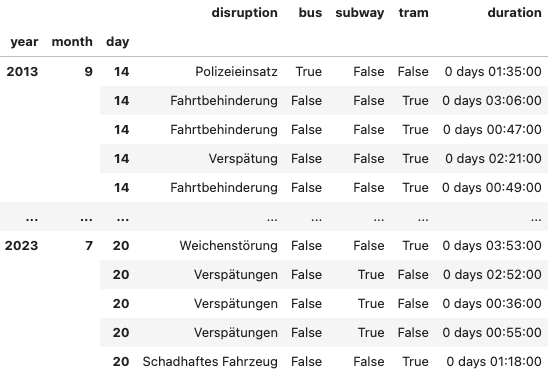


In [16]:
import regex as re

def load_traffic_data() -> pd.DataFrame:
    """ 
    Load the traffic data from the files into a pndas dataframe
    
    Returns
    --------
    traffic_data: data frame containing the traffic data
    """

    def extract_disruption(titel):
        # First attempt to find words based on the first regex
        matches = pd.Series(titel).str.findall(r'\b(?![A-Z]{3})[a-zA-ZäöüÄÖÜß]{3,}\b').tolist()
    
        # Check if matches are found
        if matches and matches[0]:  # Check if there are any matches
            return ' '.join(matches[0])  # Join the list of matches into a single string
        else:
            # If no matches found, extract text after the colon
            extracted = pd.Series(titel).str.extract(r':\s*(.*)')[0]
            return extracted if not extracted.empty else ''
        
#=======================================================================
#                     Function Main Code
#=======================================================================   
    
    traffic_data_list = []
    for file in os.listdir(traffic_data_path):
        if file.endswith('csv'):
            filePath = os.path.join(traffic_data_path, file)
            df = pd.read_csv(filePath, delimiter=';')
            traffic_data_list.append(df)

    # Prepare full data
    traffic_full_data = pd.concat(traffic_data_list, ignore_index=True)
    traffic_full_data.dropna(subset=['Verkehrsaufnahme', 'Titel', 'Linie(n)'], inplace = True) 
    traffic_full_data.drop(traffic_full_data[traffic_full_data['Titel'] == ''].index, inplace = True)
    traffic_full_data[['Verkehrsaufnahme', 'Start', 'Ende']] = traffic_full_data[['Verkehrsaufnahme', 'Start', 'Ende']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')
    traffic_full_data['day'] = traffic_full_data['Verkehrsaufnahme'].apply(lambda x: x.day if pd.notnull(x) else None).astype('Int32')
    traffic_full_data['month'] = traffic_full_data['Verkehrsaufnahme'].apply(lambda x: x.month if pd.notnull(x) else None).astype('Int32')
    traffic_full_data['year'] = traffic_full_data['Verkehrsaufnahme'].apply(lambda x: x.year if pd.notnull(x) else None).astype('Int32')
    traffic_full_data.set_index(['year', 'month', 'day'], inplace = True)

    traffic_full_data['disruption'] = traffic_full_data['Titel'].apply(extract_disruption) # extract disruption data, based on the regex
    #traffic_full_data['disruption'] = traffic_full_data['Titel'].str.extract(r'\b(?![A-Z]{3})([a-zA-ZäöüÄÖÜß]{3,})\b').fillna(traffic_full_data['Titel'].str.extract(r':\s*(.*)'))
    traffic_full_data['disruption'] = traffic_full_data['disruption'].str.replace(r'\bBadner Bahn\b', '', regex=True).str.strip() # Delete Badner Bahn from string
    
    # pattern to find tram, bus or train
    pattern_bus = r'\b\d{2}[AB]\bar'
    pattern_subway = r'\bU[1-6](?![Zz])\b'
    pattern_tram = r'\b(?:D|O|U2[Zz]|VRT|WLB|Badner Bahn|\d{1,2})(?![A-Za-z])\b'
    
    traffic_full_data['bus'] = traffic_full_data['Linie(n)'].str.contains(pattern_bus, regex=True)
    traffic_full_data['subway'] = traffic_full_data['Linie(n)'].str.contains(pattern_subway, regex=True)
    traffic_full_data['tram'] = traffic_full_data['Linie(n)'].str.contains(pattern_tram, regex=True)

    # calculate duration
    traffic_full_data['duration'] = traffic_full_data['Ende'] - traffic_full_data['Start'] 
    
    traffic_full_data.drop(['Titel', 'Beschreibung', 'Start', 'Ende', 'Linie(n)', 'Verkehrsaufnahme'], axis=1, inplace = True)
    traffic_full_data.dropna(subset = ['disruption', 'duration'], inplace = True)
    traffic_full_data.drop(traffic_full_data[traffic_full_data['disruption'].str.contains('Test', na=False)].index, inplace = True)
    
    traffic = traffic_full_data.sort_index()
    traffic.info()
    return traffic

# I know that it's slow solution and it could be better. I couldn't get a right result with 
#traffic_full_data['disruption'] = traffic_full_data['Titel'].str.extract(r'\b(?![A-Z]{3})([a-zA-ZäöüÄÖÜß]{3,})\b').fillna(traffic_full_data['Titel'].str.extract(r':\s*(.*)'))

In [17]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_traffic = load_traffic_data()
display(data_traffic)



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 94665 entries, (2013, 9, 14) to (2023, 7, 20)
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   disruption  94665 non-null  object         
 1   bus         94665 non-null  bool           
 2   subway      94665 non-null  bool           
 3   tram        94665 non-null  bool           
 4   duration    94665 non-null  timedelta64[ns]
dtypes: bool(3), object(1), timedelta64[ns](1)
memory usage: 2.0+ MB


disruption    bus  subway   tram        duration
year month day                                                            
2013 9     14       Fahrtbehinderung  False   False   True 0 days 03:06:00
           14       Fahrtbehinderung  False   False   True 0 days 00:47:00
           14             Verspätung  False   False   True 0 days 02:21:00
           14       Fahrtbehinderung  False   False   True 0 days 00:49:00
           14       Fahrtbehinderung  False   False   True 0 days 01:34:00
...                              ...    ...     ...    ...             ...
2023 7     20         Weichenstörung  False   False   True 0 days 03:53:00
           20           Verspätungen  False    True  False 0 days 02:52:00
           20           Verspätungen  False    True  False 0 days 00:36:00
           20           Verspätungen  False    True  False 0 days 00:55:00
           20   Schadhaftes Fahrzeug  False   False   True 0 days 01:18:00

[94665 rows x 5 columns]

In [18]:
# use this cell to inspect the data.

print(f"Data dimensions are: {data_traffic.shape[0]} rows and {data_traffic.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{data_traffic.index.dtype}")
print(f"\ncolumn types are: \n-----------------\n{data_traffic.dtypes}")

Data dimensions are: 94665 rows and 5 columns

index types are: 
-----------------
object

column types are: 
-----------------
disruption             object
bus                      bool
subway                   bool
tram                     bool
duration      timedelta64[ns]
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically be assigned by the hidden test, try to make sure that you covered all required points from above!

In [19]:
# use this cell to create your own tests
data_traffic['disruption'].unique()

array(['Fahrtbehinderung', 'Verspätung', 'Schadhaftes Fahrzeug',
       'Verkehrsunfall', 'Erkrankung', 'Gleisschaden', 'Rettungseinsatz',
       'Polizeieinsatz', 'Sachbeschädigung', 'Wagengebrechen',
       'Alle Fahrtbehinderung', 'Stromstörung', 'Alle Verspätung',
       'Signalstörung', 'Schadhafter Zug', 'Falschparker',
       'Verkehrsbedingt Verspätungen', 'Verkehrsstörung',
       'Verkehrsstörung Verspätungen',
       'Schadhaftes Fahrzeug Verspätungen', 'Polizeieinsatz Verspätungen',
       'erhöhtes Fahrgastaufkommen Verspätungen', 'Feuerwehreinsatz',
       'Verspätungen', 'Verkehrsunfall Verspätungen', 'Veranstaltung',
       'Fremder Verkehrsunfall', 'Rettungseinsatz Verspätungen',
       'Demonstration', 'Erkrankung eines Fahrgastes',
       'Fahrleitungsgebrechen', 'Fremder Verkehrsunfall Verspätungen',
       'Regenbogenparade Verspätungen', 'Signalstörung Verspätungen',
       'Verkehrsbedingte Verspätung Verspätungen',
       'Verkehrsbedingte Verspätungen', 'Verkeh

In [20]:
# tests DO NOT MODIFY THIS CELL!!
# final dimensions should be like this:
assert data_traffic.shape[0] > 94642
assert data_traffic.shape[0] < 94672
assert data_traffic.shape[1] == 5

In [21]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In [22]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


#### Question
Which combination of year+month+day shows the highest number of a given disruption for subway lines? 
- Implement the function below to return the result!
- You should find the respective entry/entries using pandas!
- Return the first answer if there is more than one combination fulfilling these criteria.

In [23]:
def get_day_with_most_subway_disruptions(data_frame:pd.DataFrame,
                                  disruption_type:str
                                 ) -> typing.Tuple[int,int,int]:
    year = 0
    month = 0
    day = 0
    
    filtered_df = data_frame[data_frame['subway'] == True].groupby(['year', 'month', 'day']).size()
    max_disruption = filtered_df.idxmax()

    year, month, day = max_disruption[:3]
    
    return year, month, day


In [24]:
# DO NOT MODIFY OR COPY THIS CELL!! 
year, month, day =get_day_with_most_subway_disruptions(data_traffic, 'Schadhaftes Fahrzeug')
print(f"{day}.{month}.{year} has the highest number of malfunctioning subway lines!")

24.3.2023 has the highest number of malfunctioning subway lines!


In [25]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


## Task 2: Handling Missing Values (15 Points)

If you take a closer look at the data, you will notice that a few of the observations are missing.

There is a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is essential to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 
 

_______

You talked to the meteorologists who compiled the data to find out more about what mechanisms may have caused the missing values: 

1. They told you that they do not know why some of the temperature (`temp`) and pressure (`airPressure`) readings are missing. They suspect a problem with the IT infrastructure. In any case, the propensity of temperature and pressure values to be missing does not have anything to do with the weather itself.

2. For wind intensity values of 0, the wind direction is not provided (for obvious reasons). 

Check the plausibility of these hypotheses in the data, consider the implications, and devise appropriate strategies to deal with the various missing values.

- Handle missing values for the following columns: `temp`, `airPressure`, `windDir`

To implement your strategy, you can use a range of standard mechanisms provided by Pandas.

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.
Additionally plot the average monthly sky coverage over all years.

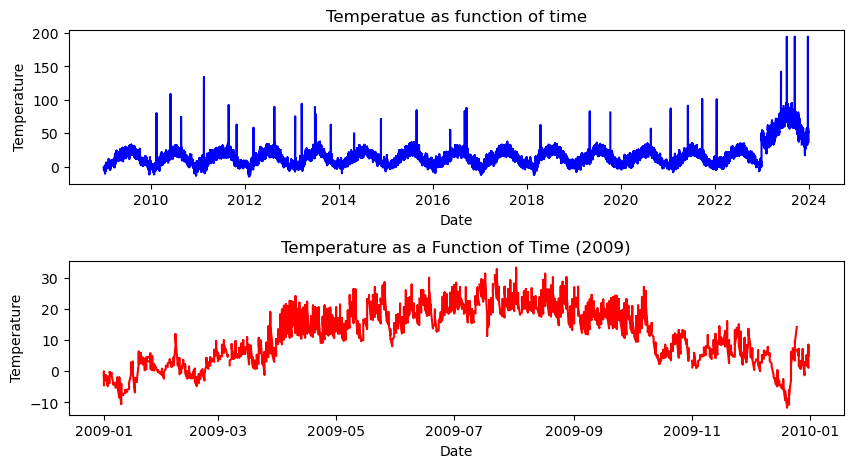

In [26]:
# plot the temperature 
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.title('Temperatue as function of time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.subplots_adjust(hspace=0.5)
plt.plot(weather_data['date'], weather_data['temp'], 'b')

# Just for fun, I'd like to have a closer look in 2009
plt.subplot(2, 1, 2)
data_2009 = weather_data[(weather_data['date'].dt.year == 2009)]
plt.title('Temperature as a Function of Time (2009)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(data_2009['date'], data_2009['temp'], 'r', label='2009')



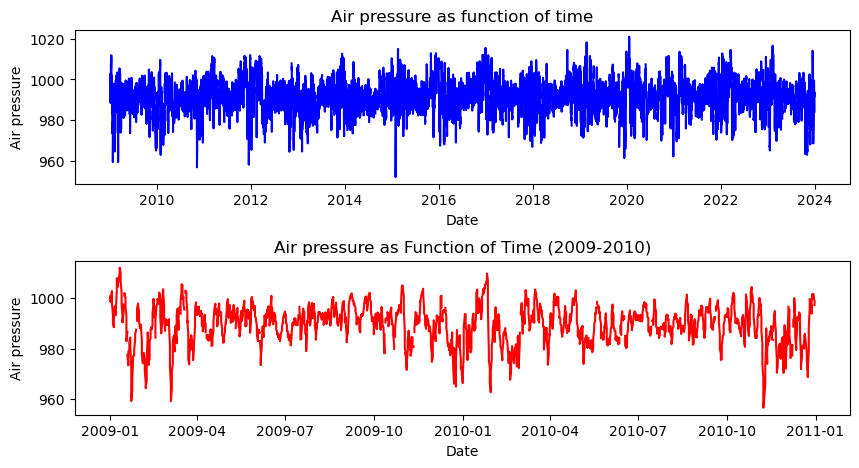

In [27]:
# plot the air pressure 

plt.figure(figsize=(10, 5))

plt.subplot(2,1,1)
plt.title('Air pressure as function of time')
plt.xlabel('Date')
plt.ylabel('Air pressure')
plt.subplots_adjust(hspace=0.5)
plt.plot(weather_data['date'], weather_data['airPressure'],'b')

# Just for fun, I'd like to have a closer look in 2009 and 2010
plt.subplot(2,1,2)
plt.title('Air pressure as Function of Time (2009-2010)')
plt.xlabel('Date')
plt.ylabel('Air pressure')
data_2009_2010 = weather_data[(weather_data['date'].dt.year == 2009) | (weather_data['date'].dt.year == 2010)]
plt.plot(data_2009_2010['date'], data_2009_2010['airPressure'], 'r')

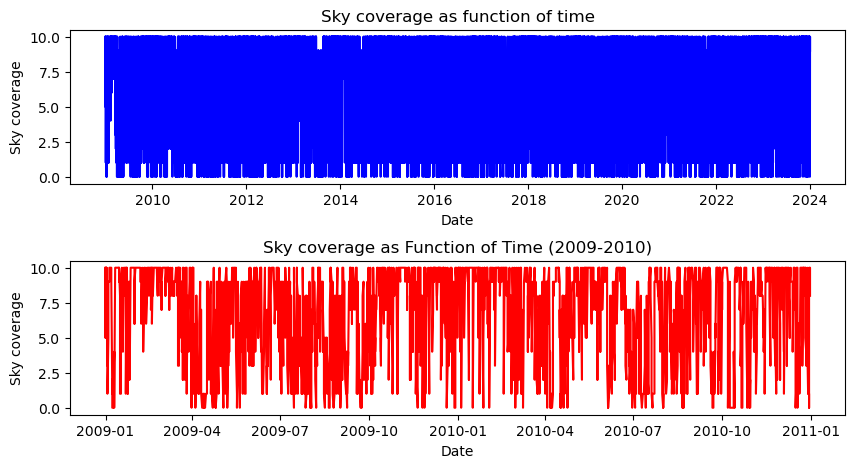

In [28]:
# plot the sky coverage 

plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.title('Sky coverage as function of time')
plt.xlabel('Date')
plt.ylabel('Sky coverage')
plt.subplots_adjust(hspace=0.5)
plt.plot(weather_data['date'], weather_data['skyCover'],'b')

# Just for fun, I'd like to have a closer look in 2009 and 2010
plt.subplot(2,1,2)
plt.title('Sky coverage as Function of Time (2009-2010)')
plt.xlabel('Date')
plt.ylabel('Sky coverage')
data_2009_2010 = weather_data[(weather_data['date'].dt.year == 2009) | (weather_data['date'].dt.year == 2010)]
plt.plot(data_2009_2010['date'], data_2009_2010['skyCover'], 'r')

### 2.1: Missing values for temperature and air pressure
Find and visualize missing values for `temp` and `airPressure` columns in the `weather_data` data frame.


#### Data inspection
First, let's visualize the missing data to get a better feel for what is happening.
- Implement the `get_data_around_missing` function below to extract and return a dataframe that only contains rows around missing (`isna`, `isnull`) values for the column indicated by `column`.
- First find missing values in the specified column
- For each missing value, create a dataframe that contain only rows with a date +- `delta_days` from the date of the missing value.
- Put the dataframes into `df_list` and return them.

In [29]:
def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    import datetime
    
    df_list = []

    missing_rows = df[df[column].isnull()]

    for _, missing_row in missing_rows.iterrows():
        missing_date = missing_row['date']
        start_interval = missing_date - datetime.timedelta(days=delta_days)
        end_interval = missing_date + datetime.timedelta(days=delta_days)
        data = df[(df['date'] >= start_interval) & (df['date'] <= end_interval)].copy()

        df_list.append(data)

    return df_list


In [30]:
# DO NOT MODIFY OR COPY THIS CELL!! 
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')

In [31]:
# tests, DO NOT MODIFY OR COPY THIS CELL!! 
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

assert 300 < len(missing_temp_df_list) < 400, "There should be between 300 and 400 missing values in temp!"
assert 300 < len(missing_airPressure_df_list) < 400, "There should be between 300 and 400 missing values in airPressure!"

assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_temp_df_list])
assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_airPressure_df_list])

336
319


In [32]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In order to be able to see the data, complete the function `plot_value_series` to plot a timeseries of a dataframe identified by `column`:


In [33]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """

    plt.figure(figsize=(10,5))
    plt.title('Missing values ' + column)
    plt.xlabel('date')
    plt.ylabel(column)
    plt.plot(df['date'],df[column], 'bo')

missing_temp_df_list[0]

date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     22  7    2009-01-22        984.4        10   1.9   92       W   
               14   2009-01-22        982.2         8   4.0   76       N   
               19   2009-01-22        980.4         1   0.3   92      NW   
           23  7    2009-01-23        972.5        10   0.7   94      SE   
               14   2009-01-23        961.2         6   4.5   79      SE   
               19   2009-01-23        959.3        10   3.5   81      SE   
           24  7    2009-01-24        963.6         7   4.6   61       W   
               14   2009-01-24        964.6         1   NaN   40       W   
               19   2009-01-24        967.1         4   3.2   69       E   
           25  7    2009-01-25        976.1         9   2.9   72       W   
               14   2009-01-25        976.7         5   5.7   53      NW   
               19   2009-01-25        977.1         2   0.8   78      NW   
           26  7    2009-01-26        977.3         9   0.3   91       E   
               14   2009-01-26        977.8         5   4.8   66      SE   
               19   2009-01-26        979.5         2   1.3   89      SE   

                     windBeauf  
year month day hour             
2009 1     22  7             3  
               14            2  
               19            1  
           23  7             3  
               14            4  
               19            3  
           24  7             3  
               14            2  
               19            2  
           25  7             3  
               14            3  
               19            1  
           26  7             1  
               14            2  
               19            2

Now we use the function to plot a missing value for `temp` and `airPressure`:

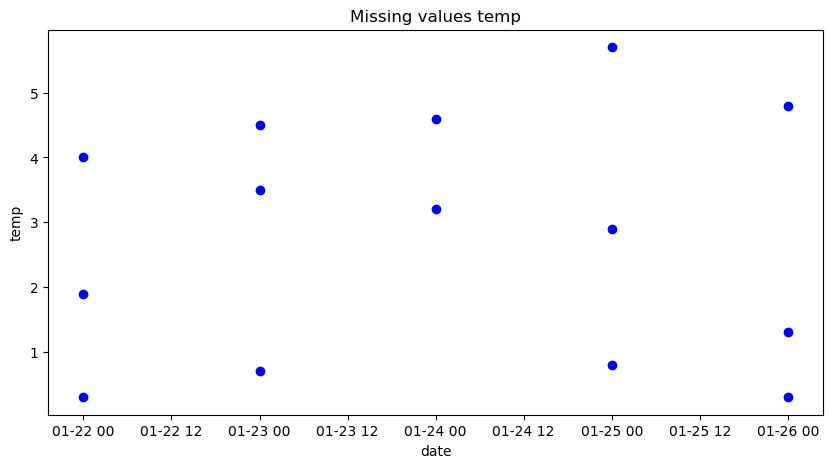

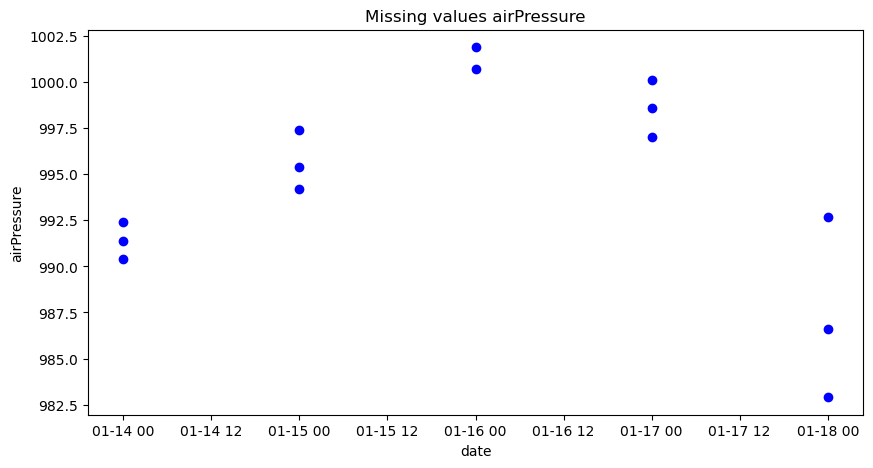

In [34]:
# tests,  DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[0], 'temp')
plot_value_series(missing_airPressure_df_list[0], 'airPressure')

In [35]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

#### Handle missing temperature values
Use the plots above and the information that was given to us by the meterologist to decide on a suitable strategy to fix the missing values.

- Implement the function below to get rid of the missing values for temperature (`temp`).
- Choose an appropriate strategy to fill in the misssing values.

In [36]:
def handle_missing_temp_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing temperature values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    missing_temp_indices = df_ret[df_ret['temp'].isnull()].index

    # approx with mean value
    
    for idx in missing_temp_indices:
        
        before = df_ret.loc[:idx].iloc[:-1] 
        after = df_ret.loc[idx:].iloc[1:]  

        nearest_before = before[before['temp'].notnull()].iloc[-1:] 
        nearest_after = after[after['temp'].notnull()].iloc[:1]    

        if not nearest_before.empty and not nearest_after.empty:
            mean_temp = (nearest_before['temp'].values[0] + nearest_after['temp'].values[0]) / 2
            df_ret.at[idx, 'temp'] = mean_temp
        else:
            hour = idx[-1]
            non_null_temps = df_ret[(df_ret.index.get_level_values('hour') == hour) & 
                                (df_ret['temp'].notnull())]
            if len(non_null_temps) >= 2:
                # Sort by the multi-index and get the two closest rows in terms of date
                non_null_temps = non_null_temps.sort_index()
                before_idx = non_null_temps.loc[:idx].iloc[-2:]['temp']  # Two closest before
                after_idx = non_null_temps.loc[idx:].iloc[:2]['temp']    # Two closest after

                # Combine before and after using pd.concat
                closest_temps = pd.concat([before_idx, after_idx])

                # Calculate the mean of these closest two non-null values
                mean_temp = closest_temps.mean()

                # Fill the missing temperature with the calculated mean
                df_ret.at[idx, 'temp'] = mean_temp

    return df_ret

Plot the fixed stretch of temp values from above, and compare to the unmodified version:

In [37]:
missing_temp_idx = 0

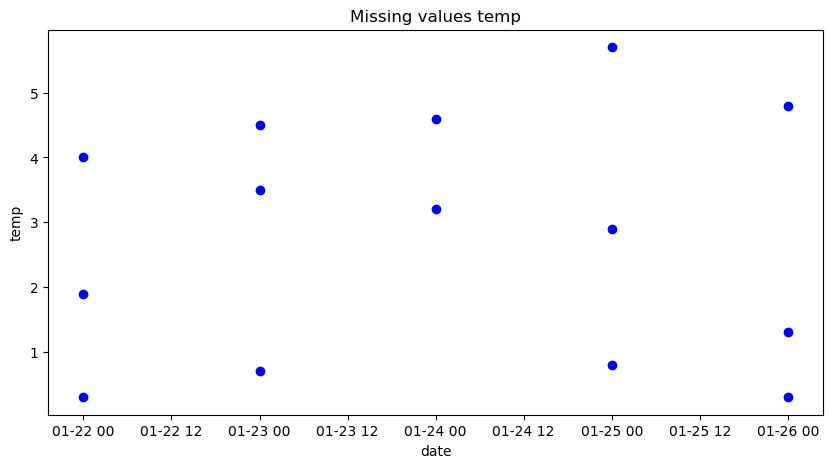

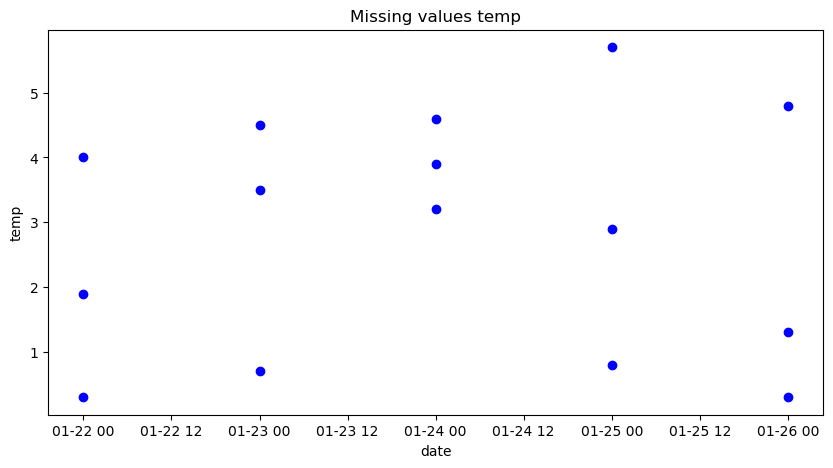

In [38]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[missing_temp_idx], 'temp')
plot_value_series(handle_missing_temp_values(missing_temp_df_list[missing_temp_idx]), 'temp')

#### Handle missing air pressure values

Do the same for the air pressure values:

- Implement the function below to get rid of the missing values for air pressure (`airPressure`).
- Choose an appropriate strategy to fill in the misssing values.

In [39]:
# Regression would be a better option, but I don't know how to impliment it

def handle_missing_airPressure_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing air pressure values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    missing_airPressure_indices = df_ret[df_ret['airPressure'].isnull()].index
    
    for idx in missing_airPressure_indices:
        if idx[-1] == (19 or 7):
            null_airPressure_day = df_ret.loc[idx[:3]]    
            not_null_airPressure = null_airPressure_day[~null_airPressure_day['airPressure'].isnull()]['airPressure']
            difference = not_null_airPressure.diff().iloc[-1]
            if idx[-1] == 19:
                df_ret.at[idx, 'airPressure'] = not_null_airPressure.loc[14] + difference
            else:
                df_ret.at[idx, 'airPressure'] = not_null_airPressure.loc[14] - difference
        else:
            null_airPressure_day = df_ret.loc[idx[:3]]    
            df_ret.at[idx, 'airPressure'] = null_airPressure_day[~null_airPressure_day['airPressure'].isnull()]['airPressure'].mean()
    return df_ret

Plot the fixed stretch of airPressure values from above:

In [40]:
missing_apr_idx = 0

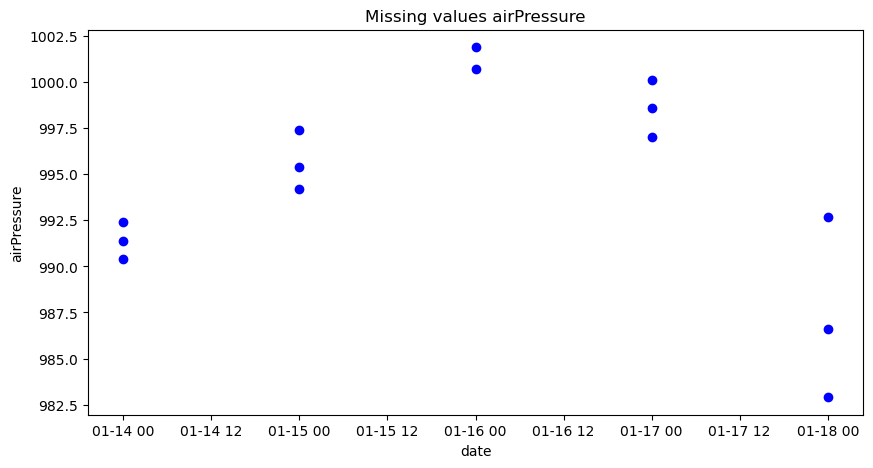

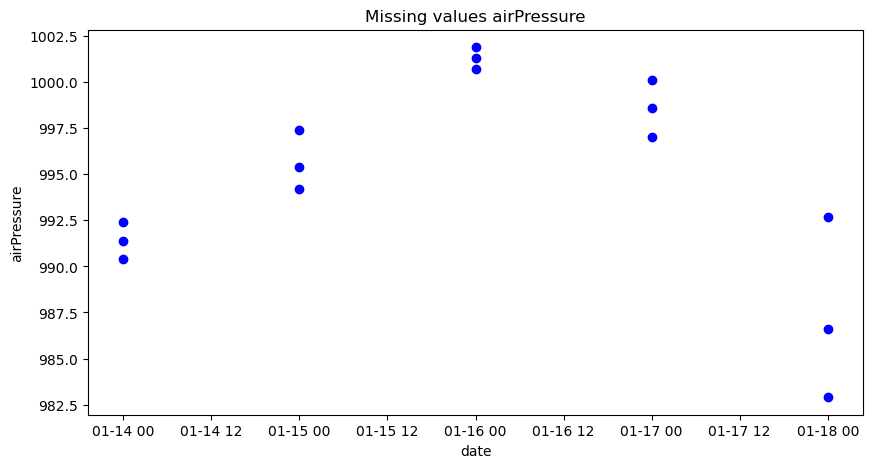

In [41]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_airPressure_df_list[missing_apr_idx], 'airPressure')
plot_value_series(handle_missing_airPressure_values(missing_airPressure_df_list[missing_apr_idx]), 'airPressure')

In [42]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# the function to get the short dataframes around missing values should now return an empty list if we fix all temp values!
empty_temp_list = get_data_around_missing(handle_missing_temp_values(weather_data), 'temp')
empty_airPressure_list = get_data_around_missing(handle_missing_airPressure_values(weather_data), 'airPressure')
assert len(empty_temp_list) == 0
assert len(empty_airPressure_list) == 0

In [43]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.2 Missing wind direction values

#### Data inspection
Check the assumption for missing wind direction values and handle the missing wind direction values in an appropriate way.

In [44]:
# write some code to check the assumtion for missing values of windDir

empty_wind_list = get_data_around_missing(weather_data, 'windDir', 2)
print(len(empty_wind_list))

210


#### Handle missing wind direction values
Implement a function that fixes the missing wind direction values.

In [45]:
# I would prefer to discard these missing values, but I need shape[0] the same as it was after processing the missing values
def handle_missing_windDir_values(df:pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()
    
    missing_windDir_indices = df_ret[df_ret['windDir'].isnull()].index
    
    for idx in missing_windDir_indices:
        null_windDir_day = df_ret.loc[idx[:3]]    
        not_null_winDir = null_windDir_day[~null_windDir_day['windDir'].isnull()]['windDir']
        df_ret.at[idx, 'windDir'] = not_null_winDir.iloc[0]

    return df_ret

In [46]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Apply the windDir fix and check if any missing values remain
fix_wind_dir = handle_missing_windDir_values(weather_data)
assert fix_wind_dir[fix_wind_dir['windDir'].isnull()].empty

In [47]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.3 Combine all fixes to get clean data

In [48]:
def handle_missing_values_weather(data:pd.DataFrame) -> pd.DataFrame:
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    df_handled_missing_values_temp = handle_missing_temp_values(data)
    df_handled_missing_values_airpressure = handle_missing_airPressure_values(data)
    df_handled_missing_values_wind = handle_missing_windDir_values(data)

    data = pd.concat([df_handled_missing_values_temp, df_handled_missing_values_airpressure, df_handled_missing_values_wind], axis=0)
    data = data.groupby(data.index).first()
    data.index = pd.MultiIndex.from_tuples(data.index, names=['year', 'month', 'day', 'hour'])

    return data

In [49]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_complete = handle_missing_values_weather(weather_data)

In [50]:
print(f"Before: \n---------\n{weather_data.isna().sum()}")
print(f"\nAfter: \n---------\n{weather_data_complete.isna().sum()}")

Before: 
---------
date             0
airPressure    319
skyCover         0
temp           336
hum              0
windDir        210
windBeauf        0
dtype: int64

After: 
---------
date           0
airPressure    0
skyCover       0
temp           0
hum            0
windDir        0
windBeauf      0
dtype: int64


In [51]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# check if missing values are no longer present
assert not weather_data_complete.isna().any().any()
assert weather_data_complete.shape[0] == weather_data.shape[0]
assert weather_data_complete.shape[1] == weather_data.shape[1]

## Task 3: Handling Outliers (10 Points)

Additionally to the missing values, the dataset also seems to have some strange values, that are probably outliers. 
When confronted with the data, the meterologist gave you a bit more information:


1. Sometimes the temperture readings seem to be off, without any good reason.

2. In the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

3. In the `daily_weather_data`, the precipitation column contains some non-numeric values.

4. The precipitation sensor usually produces wrong values when hail is involved.






### 3.1 Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

#### Investigation
Implement the function below to create a plot of the temperature values (`temp`) over time. Additionally create a histogram with reasonable bins to identify the outliers:

In [52]:
def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    
    """

    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.title('Temperature values over time for the whole dataframe')
    plt.xlabel('Date')
    plt.ylabel('Temperatur')
    plt.subplots_adjust(hspace=0.5)
    plt.plot(df['date'], df['temp'], 'b')

    plt.subplot(2,1,2)
    plt.xlabel('Temperatur')
    plt.ylabel('Number')
    plt.hist(df['temp'], bins=50)


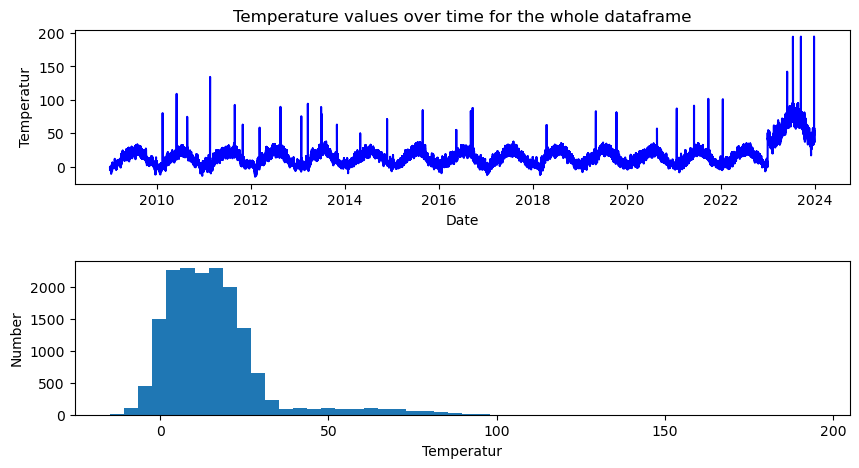

In [53]:
# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data_complete)

In [54]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In the next cell, select a random outlier (e.g. the first) and plot the temperature curve around the outlier.

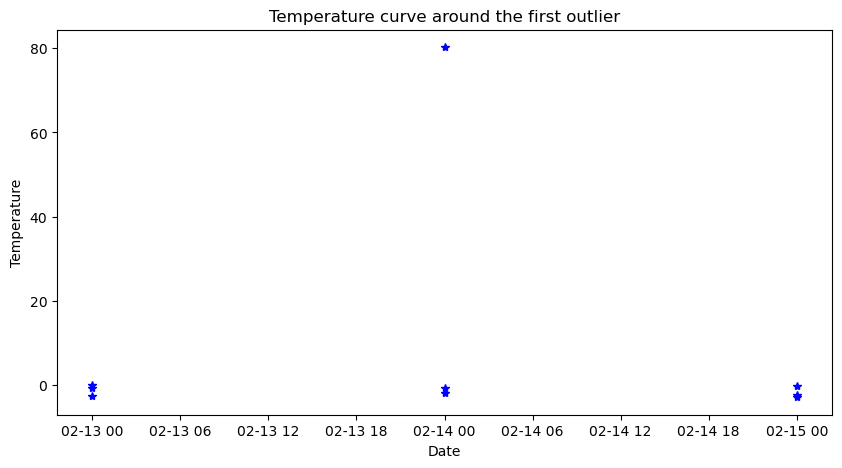

In [55]:
import datetime

zscore = abs((weather_data_complete['temp']-weather_data_complete['temp'].mean()) / weather_data_complete['temp'].std())
outliners = weather_data[zscore > 3] # Let's take a look on a huge deviation
first_outliner = outliners.iloc[0]
first_outliner_date = first_outliner['date']

days_around = 1
start = first_outliner_date - datetime.timedelta(days=days_around)
end = first_outliner_date + datetime.timedelta(days=days_around)
df = weather_data[((weather_data['date'] >= start) & (weather_data['date'] <= end))]

plt.figure(figsize=(10,5))
plt.title('Temperature curve around the first outlier')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(df['date'], df['temp'], 'b*')


In [56]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [57]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    cleaned_data = noisy_data.copy()
    
    zscore = abs((cleaned_data['temp']-cleaned_data['temp'].mean())/cleaned_data['temp'].std())
    outliers = cleaned_data[zscore > 1.25] # 1.25 zscore assumed to be a standard deviations from the mean. 

    # simply drop is not allowed
    # cleaned_data = cleaned_data[~cleaned_data['date'].isin(outliers['date'])]
    
    # Let's take an avarage bitween last and next day for the same hour
    outliers_indices = outliers.index
    
    for idx in outliers_indices:
        hour = idx[-1]
        normal_temps = cleaned_data[(cleaned_data.index.get_level_values('hour') == hour) & 
                                (~cleaned_data['temp'].isin(outliers['temp']))]
        
        normal_temps = normal_temps.sort_index()
        before_idx = normal_temps.loc[:idx].iloc[-2:]['temp']  # Two closest before
        after_idx = normal_temps.loc[idx:].iloc[:2]['temp']    # Two closest after

        # Combine before and after using pd.concat
        closest_temps = pd.concat([before_idx, after_idx])

        # Calculate the mean of these closest two non-null values
        mean_temp = closest_temps.mean()

        # Fill the missing temperature with the calculated mean
        cleaned_data.at[idx, 'temp'] = mean_temp

    return cleaned_data

count    16434.000000
mean        13.826313
std          9.802691
min         -3.300000
25%          5.600000
50%         13.300000
75%         20.900000
max         34.200000
Name: temp, dtype: float64


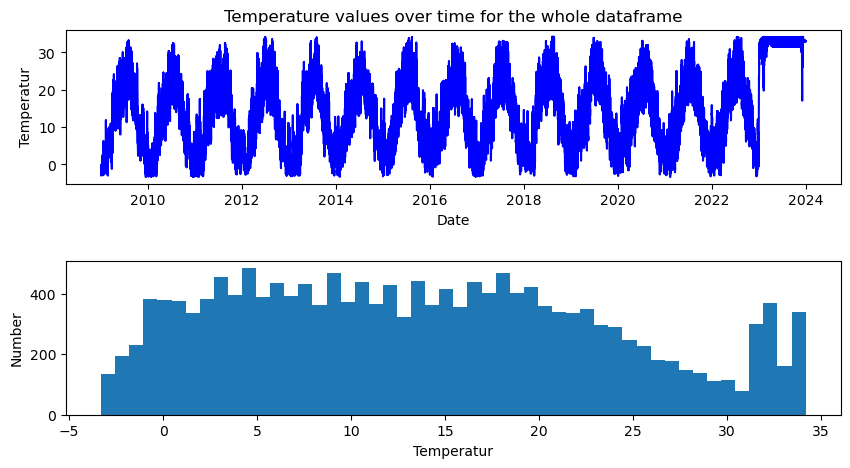

In [58]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data_complete)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

In [59]:
# test, DO NOT MODIFY OR COPY THIS CELL!!

# check if new missing values were introduced
assert not weather_data_cleaned.isna().any().any()
# check if outliers were simply dropped
assert weather_data_cleaned.shape == weather_data_complete.shape

In [60]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [61]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.2 Wind speed outliers

The second outlier problem was, that in the timespan from early May 2017 until November 2017, the wind sensor was defective: it might have displayed wrong values for winds from NE direction.

Double check if this is true, and if it is, fix the values appropriately.

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumptions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early May 2017 until November 2017)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumption regarding the wind direction is true (errors only from NE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [62]:
def analyze_wind_range(df:pd.DataFrame) -> typing.Tuple[int, typing.List[str]]:
    """
    Plot analysis plots for the wind data. Print outputs about relevant data 
    and return the relevant values as indicated.

    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    wind_dir_outliers: list of wind direction string code, for which outliers where found
    num_outliers: number of found outliers

    """
    from datetime import datetime
    
    num_outliers = 0  # return a value that reflects how many outliers you identified
    wind_dir_outliers = [] # a list of the string codes for wind directions where you identified outliers from

    start_date = datetime.strptime("01.05.2017", "%d.%m.%Y")
    end_date = datetime.strptime("30.11.2017", "%d.%m.%Y")
    suspicious_data = df[((df['date'] >= start_date) & (df['date'] <= end_date))]

    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.title('Wind speed data over early May 2017 until November 2017')
    plt.xlabel('Date')
    plt.ylabel('WindBeauf')
    plt.subplots_adjust(hspace=0.5)
    plt.plot(suspicious_data['date'], suspicious_data['windBeauf'], 'b')

    plt.subplot(2,1,2)
    plt.xlabel('WindBeauf')
    plt.ylabel('Number')
    plt.hist(df['windBeauf'], bins=50)

    zscore = abs((suspicious_data['windBeauf']-suspicious_data['windBeauf'].mean())/suspicious_data['windBeauf'].std())
    outliers = suspicious_data[zscore > 3] # --> only NE. 
    num_outliers = outliers[outliers['windDir']=='NE']['windDir'].count()
    wind_dir_outliers = list(outliers[outliers['windDir']=='NE']['windDir'])

    print('The number of outliers', num_outliers)
    print(wind_dir_outliers)
    
    return wind_dir_outliers, num_outliers


The number of outliers 29
['NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE', 'NE']


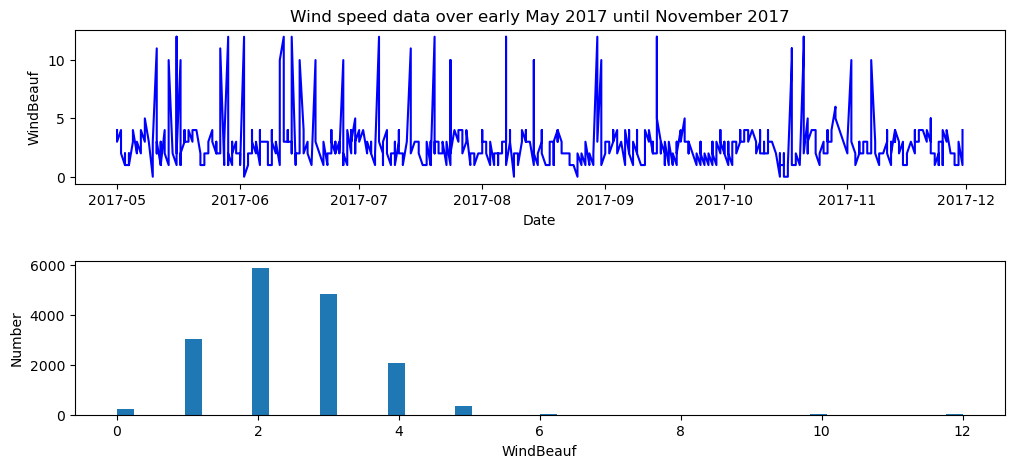

In [63]:
# DO NOT MODIFY OR COPY THIS CELL!!
wind_dir_outliers, num_outliers = analyze_wind_range(weather_data_complete)

In [64]:
assert 0 < num_outliers < 500, "there should be more than zero but less than 500 outliers!"
assert len(wind_dir_outliers) > 0, "there should be at least one wind direction!"
assert isinstance(wind_dir_outliers[0], str), "the wind direction codes are strings with two characters!"
assert len(wind_dir_outliers[0]) == 2, "the wind direction codes are strings with two characters!"

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Fix wind sensor outliers
Fix the values appropriately. Implement a function that compensates for the problem you found.

In [65]:
def fix_windBeauf_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains potential faulty wind values

    Returns
    -------
    df_ret: data frame with fixed wind values
    """

    from datetime import datetime
    
    df_ret = df.copy()

    start_date = datetime.strptime("01.05.2017", "%d.%m.%Y")
    end_date = datetime.strptime("30.11.2017", "%d.%m.%Y")
    suspicious_data = df_ret[((df_ret['date'] >= start_date) & (df_ret['date'] <= end_date))]

    zscore = abs((suspicious_data['windBeauf']-suspicious_data['windBeauf'].mean())/suspicious_data['windBeauf'].std())
    outliers = suspicious_data[zscore > 1.65] 

    outliers_indices = outliers.index

    # Let us assume that the wind speed has not changed since the last normal value in the same day
    for idx in outliers_indices:
        normal_values = df_ret.loc[idx[:3]]
        normal_values = normal_values[normal_values['windDir'] != 'NE']['windBeauf']
        normal_value = normal_values.iloc[0]
        df_ret.at[idx, 'windBeauf'] = normal_value

    return df_ret

The number of outliers 0
[]


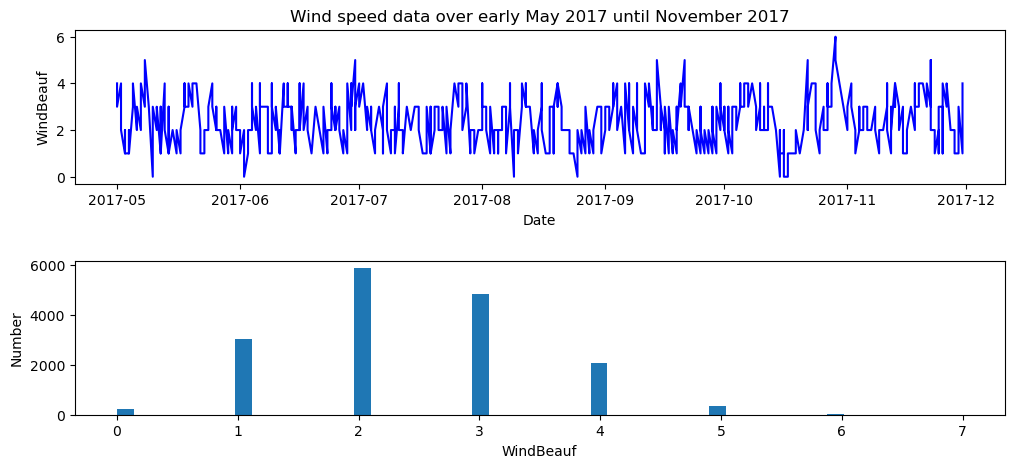

In [66]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
weather_data_fix_wind = fix_windBeauf_values(weather_data_complete)
wind_dir_outliers_fixed, num_outliers_fixed = analyze_wind_range(weather_data_fix_wind)

In [67]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
print(num_outliers_fixed)
assert num_outliers_fixed == 0, "now no outliers should be found"
assert len(wind_dir_outliers_fixed) == 0, "now no outliers should be found, so no directions!"
assert weather_data_fix_wind.shape == weather_data_complete.shape

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

0


### 3.3 Daily weather data: precipitation

When loading the data, we separated the precipitation data into the `daily_weather_data` dataframe.
This dataframe also has an issues:

- The `precip` column contains some non-numeric values 

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/weather_description_<year>.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [68]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set(df.loc[pd.to_numeric(df['precip'], errors='coerce').isna(), 'precip'])

    return non_numeric_values

In [69]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


In [70]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert isinstance(non_numeric_values, set) , "make sure to return a set, so no duplicate values can be returned!!"
assert len(non_numeric_values) > 0, "there should be some non-numeric values in daily_weather_data!"
assert isinstance(list(non_numeric_values)[0], str), "only return the non-numeric values as strings!"

#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/weather_description_<year>.txt` and the other numeric values in the `precip` column.

In [71]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
 
    ret_df = df.copy()
    non_numeric_mask = pd.to_numeric(ret_df['precip'], errors='coerce').isna()
    ret_df.loc[non_numeric_mask, 'precip'] = np.random.uniform(0, 0.1)
    ret_df['precip'] = ret_df['precip'].astype(float)
    
    return ret_df

In [72]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [73]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

### Combining the fixes

In [74]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [75]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data_complete)

In [76]:
weather_data_complete

date  airPressure  skyCover   temp  hum windDir  \
year month day hour                                                         
2009 1     1   7    2009-01-01        999.7        10  -4.50   79       W   
               14   2009-01-01        998.8         5  -0.10   71      NW   
               19   2009-01-01       1000.7        10  -1.80   72      NW   
           2   7    2009-01-02        999.6        10  -3.00   67       W   
               14   2009-01-02        998.5         9  -1.30   66       W   
...                        ...          ...       ...    ...  ...     ...   
2023 12    30  14   2023-12-30        993.2         4  53.42   58       W   
               19   2023-12-30        993.6         0  44.78   78       W   
           31  7    2023-12-31        988.8        10  37.76   96      SE   
               14   2023-12-31        985.1        10  38.66   88      SE   
               19   2023-12-31        984.1         9  37.22   89       N   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2  
...                        ...  
2023 12    30  14            3  
               19            2  
           31  7             2  
               14            0  
               19            1  

[16434 rows x 7 columns]

## Task 4: Aggregate values (5 Points)

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe and aggregate them into the folling cprecipp_wvaluelyMin`: min of `precip`



In [77]:
def aggregate_daily(hourly_data, daily_data):
    agg_functions = {
        'temp': ['min', 'max', 'mean', 'median'],
        'hum': ['min', 'max', 'mean'],
        'windBeauf': ['min', 'max', 'mean']}
    
    hourly_data_agg = hourly_data.groupby(level=["year", "month", "day"]).agg(agg_functions)
    
    hourly_data_agg.columns = [
        'temp_dailyMin', 'temp_dailyMax', 'temp_dailyMean', 'temp_dailyMedian', 
        'hum_dailyMin', 'hum_dailyMax', 'hum_dailyMean', 
        'wind_dailyMin', 'wind_dailyMax', 'wind_dailyMean']

    daily_data['precipType'] = daily_data['precipType'].replace(np.nan, 'no precip')
    
    hourly_data_agg = pd.concat([daily_data,hourly_data_agg], axis=1)
    
    return hourly_data_agg

In [78]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

len(agg_daily_data.columns)

13

In [79]:
# DO NOT MODIFY OR COPY THIS CELL!!
agg_daily_data =  aggregate_daily(weather_data_finished, daily_weather_data_finished)
display(agg_daily_data)
assert len(agg_daily_data.columns) >= 11

date    precip precipType  temp_dailyMin  temp_dailyMax  \
year month day                                                                 
2009 1     1   2009-01-01  0.000000  no precip      -1.850000      -0.100000   
           2   2009-01-02  0.098751       snow      -3.000000      -1.300000   
           3   2009-01-03  0.000000  no precip      -1.700000      -1.325000   
           4   2009-01-04  0.098751       snow      -1.646875      -0.200000   
           5   2009-01-05  0.098751       snow      -1.300000      -0.600000   
...                   ...       ...        ...            ...            ...   
2023 12    27  2023-12-27  0.000000  no precip      32.959998      33.104977   
           28  2023-12-28  0.000000  no precip      32.960001      33.105124   
           29  2023-12-29  0.000000  no precip      32.959999      33.105051   
           30  2023-12-30  0.000000  no precip      32.960000      33.105088   
           31  2023-12-31  5.400000       rain      32.960000      33.105069   

                temp_dailyMean  temp_dailyMedian  hum_dailyMin  hum_dailyMax  \
year month day                                                                 
2009 1     1         -1.250000         -1.800000            71            79   
           2         -2.000000         -1.700000            66            68   
           3         -1.570833         -1.687500            70            83   
           4         -0.782292         -0.500000            62            75   
           5         -0.866667         -0.700000            64            80   
...                        ...               ...           ...           ...   
2023 12    27        33.048576         33.080752            59            82   
           28        33.048651         33.080827            84            96   
           29        33.048613         33.080790            44            66   
           30        33.048632         33.080808            58            78   
           31        33.048623         33.080799            88            96   

                hum_dailyMean  wind_dailyMin  wind_dailyMax  wind_dailyMean  
year month day                                                               
2009 1     1        74.000000              2              2        2.000000  
           2        67.000000              0              3        1.666667  
           3        74.333333              2              2        2.000000  
           4        66.666667              3              4        3.666667  
           5        73.333333              2              4        3.000000  
...                       ...            ...            ...             ...  
2023 12    27       69.333333              2              2        2.000000  
           28       91.666667              1              2        1.333333  
           29       55.000000              2              4        3.000000  
           30       66.333333              2              3        2.666667  
           31       91.000000              0              2        1.000000  

[5478 rows x 13 columns]

In [80]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"

In [81]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

## Task 5: Merge Traffic and weather datasets (5 Points)

Merge the `agg_daily_data` and `data_traffic` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [82]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Neither of the tables contain missing data

print(f"traffic data, missing data (should be 0): \n{data_traffic.isna().sum()}")
print(f"weather data, missing data (should be 0): \n{agg_daily_data.isna().sum()}")

assert not data_traffic.isna().any().any(), "we should have eliminated all missing values!!"
assert not agg_daily_data.isna().any().any(), "we should have eliminated all missing values!!"

traffic data, missing data (should be 0): 
disruption    0
bus           0
subway        0
tram          0
duration      0
dtype: int64
weather data, missing data (should be 0): 
date                0
precip              0
precipType          0
temp_dailyMin       0
temp_dailyMax       0
temp_dailyMean      0
temp_dailyMedian    0
hum_dailyMin        0
hum_dailyMax        0
hum_dailyMean       0
wind_dailyMin       0
wind_dailyMax       0
wind_dailyMean      0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5478 entries, (2009, 1, 1) to (2023, 12, 31)
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5478 non-null   datetime64[ns]
 1   precip            5478 non-null   float64       
 2   precipType        5478 non-null   object        
 3   temp_dailyMin     5478 non-null   float64       
 4   temp_dailyMax     5478 non-null   float64       
 5   temp_dailyMean    5478 non-null   float64       
 6   temp_dailyMedian  5478 non-null   float64       
 7   hum_dailyMin      5478 non-null   int64         
 8   hum_dailyMax      5478 non-null   int64         
 9   hum_dailyMean     5478 non-null   float64       
 10  wind_dailyMin     5478 non-null   int64         
 11  wind_dailyMax     5478 non-null   int64         
 12  wind_dailyMean    5478 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(4), object(1)
mem

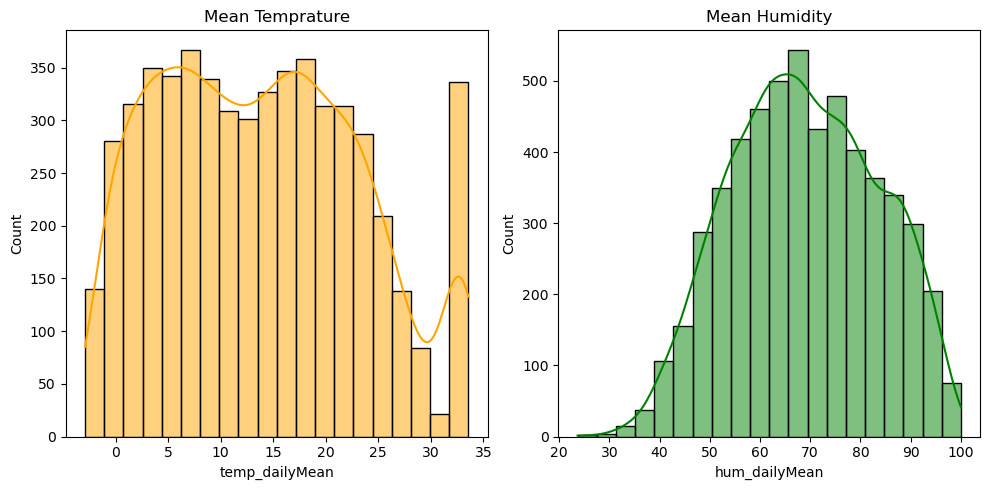

In [83]:
# use this cell for experimentation / analysis for merging data
agg_daily_data.info()
data_traffic.info()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(x=agg_daily_data['temp_dailyMean'], bins=20, kde=True, color='orange')
plt.title('Mean Temprature')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(x=agg_daily_data['hum_dailyMean'], bins=20, kde=True, color='green')
plt.title('Mean Humidity')

# Display the plots
plt.tight_layout()
plt.show()

In [84]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    merged_data = weather_df.merge(traffic_df, left_index=True, right_index=True)
    
    return merged_data

In [85]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_traffic)
data_merged

date  precip precipType  temp_dailyMin  temp_dailyMax  \
year month day                                                               
2013 9     14  2013-09-14     4.1       rain          12.50          18.80   
           14  2013-09-14     4.1       rain          12.50          18.80   
           14  2013-09-14     4.1       rain          12.50          18.80   
           14  2013-09-14     4.1       rain          12.50          18.80   
           14  2013-09-14     4.1       rain          12.50          18.80   
...                   ...     ...        ...            ...            ...   
2023 7     20  2023-07-20     0.1       rain          31.64          34.07   
           20  2023-07-20     0.1       rain          31.64          34.07   
           20  2023-07-20     0.1       rain          31.64          34.07   
           20  2023-07-20     0.1       rain          31.64          34.07   
           20  2023-07-20     0.1       rain          31.64          34.07   

                temp_dailyMean  temp_dailyMedian  hum_dailyMin  hum_dailyMax  \
year month day                                                                 
2013 9     14            16.00             16.70            65            97   
           14            16.00             16.70            65            97   
           14            16.00             16.70            65            97   
           14            16.00             16.70            65            97   
           14            16.00             16.70            65            97   
...                        ...               ...           ...           ...   
2023 7     20            32.72             32.45            36            58   
           20            32.72             32.45            36            58   
           20            32.72             32.45            36            58   
           20            32.72             32.45            36            58   
           20            32.72             32.45            36            58   

                hum_dailyMean  wind_dailyMin  wind_dailyMax  wind_dailyMean  \
year month day                                                                
2013 9     14       76.333333              3              4        3.666667   
           14       76.333333              3              4        3.666667   
           14       76.333333              3              4        3.666667   
           14       76.333333              3              4        3.666667   
           14       76.333333              3              4        3.666667   
...                       ...            ...            ...             ...   
2023 7     20       44.333333              2              4        3.000000   
           20       44.333333              2              4        3.000000   
           20       44.333333              2              4        3.000000   
           20       44.333333              2              4        3.000000   
           20       44.333333              2              4        3.000000   

                          disruption    bus  subway   tram        duration  
year month day                                                              
2013 9     14       Fahrtbehinderung  False   False   True 0 days 03:06:00  
           14       Fahrtbehinderung  False   False   True 0 days 00:47:00  
           14             Verspätung  False   False   True 0 days 02:21:00  
           14       Fahrtbehinderung  False   False   True 0 days 00:49:00  
           14       Fahrtbehinderung  False   False   True 0 days 01:34:00  
...                              ...    ...     ...    ...             ...  
2023 7     20         Weichenstörung  False   False   True 0 days 03:53:00  
           20           Verspätungen  False    True  False 0 days 02:52:00  
           20           Verspätungen  False    True  False 0 days 00:36:00  
           20           Verspätungen  False    True  False 0 days 00:55:00  
           20

In [86]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
print(data_merged.shape)
assert data_merged.shape[0] > 90000, "there should be more than 90.000 rows in the merged dataset"
assert data_merged.shape[1] >= 16, "5 column for traffic, 11 feature columns from weather data"


(94665, 18)


## Store processed data for Tasks 6-8

Here we export the prepared dataset for usage in the notebook B.
If you encounter problems with the first five tasks, you can load a pickled `DataFrame` containing already merged and preprocessed weather and traffic datasets. You can use this data to complete tasks 6-8 in notebook B. 

In [87]:
with open(os.path.join(os.environ["HOME"],"data_processed.pickle"),"wb") as fp:
    pickle.dump(data_merged, fp)  